In [267]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import funcs
import imp
import random
imp.reload(funcs)


<module 'funcs' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\intelligence_tRNS\\tRNS-Intelligence\\processing\\funcs.py'>

In [268]:
exp_info = funcs.load_info()
subjects_behavior = funcs.load_subjects_behavior()

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  subject_id = subjects_behavior.loc[row, 'subject id']


### Accuracy

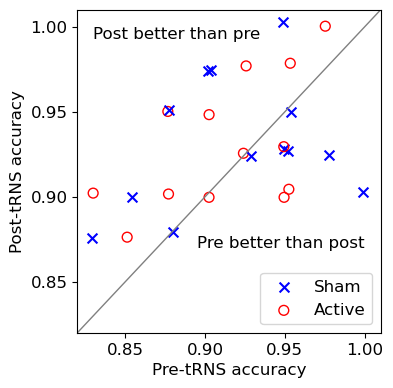

In [269]:
# accuracy
task_times = ['pre', 'post']
subjects_accuracy = np.empty([26, 2]) # 26 subjects, 2 task times

for subject_id in range (1,27):
    for task_time in range(2): # 0=pre and 1=post
        filtered_rows = subjects_behavior[
            (subjects_behavior['subject id'] == subject_id) &
            (subjects_behavior['task time'] == task_times[task_time])
        ]
        corrects = filtered_rows['correct'].sum()
        subjects_accuracy[subject_id-1, task_time] = corrects / len(filtered_rows)

# plot
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10*cm, 10*cm))
markersize = 50
for subject_id in range(1,27):
    fluc_level = 0.003
    fluc_x, fluc_y = random.uniform(-1*fluc_level, fluc_level), random.uniform(-1*fluc_level, fluc_level)
    # fluc_x, fluc_y = 0, 0
    isActive = 1 if exp_info[exp_info['subject id'] == subject_id]['Condition'].iloc[0] == 'Active' else 0
    coord = subjects_accuracy[subject_id-1, :]
    # ax.scatter(coord[0]+fluc_x, coord[1]+fluc_y, s=50, c='red' if isActive else 'blue', marker='o' if isActive else 'x')
    if isActive:
        ax.scatter(coord[0]+fluc_x, coord[1]+fluc_y, s=markersize, edgecolors='red', facecolors='none', marker='o', label='Active' if subject_id == 2 else "")
    else:
        ax.scatter(coord[0]+fluc_x, coord[1]+fluc_y, s=markersize, color='blue', marker='x', label='Sham' if subject_id == 1 else "")

# Plot line from (0,0) to (1,1)
matplotlib.rcParams.update({'font.size': 12})
ax.plot([0, 1.1], [0, 1.1], color='grey', linewidth=1)
ax.text(0.83, 0.993, 'Post better than pre', fontsize=12)
ax.text(0.895, 0.87, 'Pre better than post', fontsize=12)

ax.set_xlim([0.82, 1.01])
ax.set_ylim([0.82, 1.01])

# ax.set_xlim([0.7, 1.01])
# ax.set_ylim([0.7, 1.01])

ax.set_xticks((0.85, 0.9, 0.95, 1.0))
ax.set_yticks((0.85, 0.9, 0.95, 1.0))
ax.set_xlabel('Pre-tRNS accuracy')
ax.set_ylabel('Post-tRNS accuracy')
ax.legend(loc='lower right', fontsize=12)
# Adjust layout and margins
# plt.tight_layout(pad=1.0)
fig.subplots_adjust(left=0.2, bottom=0.14, right=0.97, top=0.96)
# plt.title(fig_title, pad=3)
save_path = os.path.join('..', '..', '..', 'paper', 'behavior', 'coord_prepost_all.png')
plt.savefig(save_path, format='png', dpi=600)

plt.show()

### Reaction time

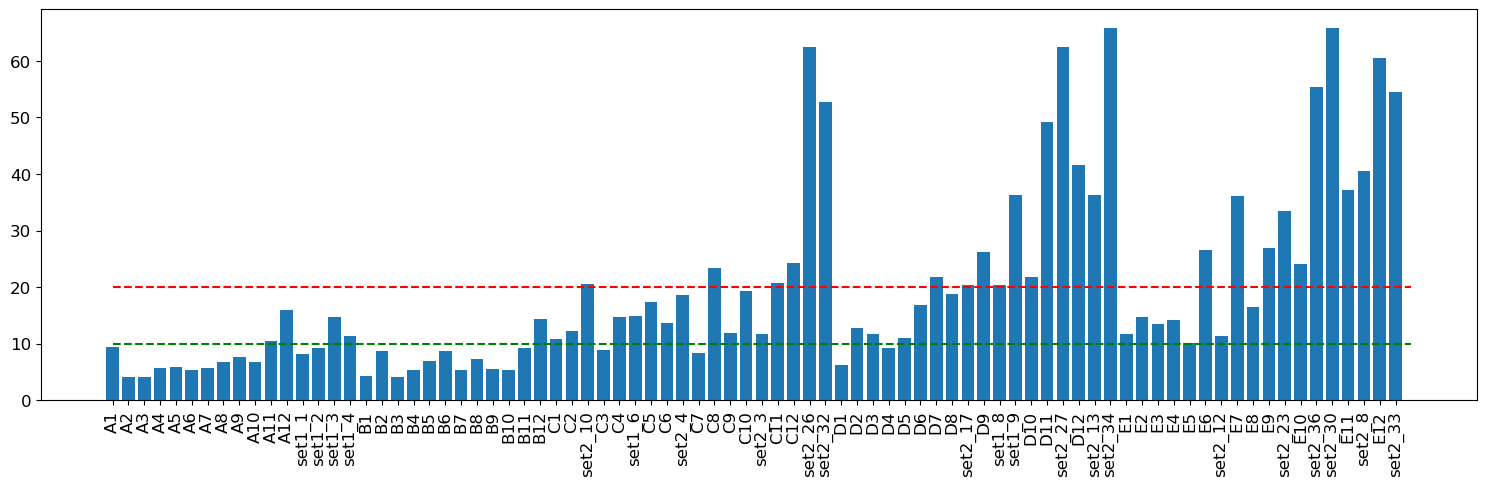

In [275]:
rpm_difficulty = pd.DataFrame(columns=['question', 'average time', 'difficulty'])
rpm_difficulty['question'] = rpm_answers['question'][0:82]
df = subjects_behavior[(subjects_behavior['reaction time'] != 0) & (subjects_behavior['task time'] == 'pre')]
for i in range(82):
    question_index = rpm_difficulty['question'][i]
    rts = df[df['question'] == question_index]['reaction time']
    rpm_difficulty['average time'][i] = rts.mean()
    

fig = plt.figure(figsize=(15, 5))
plt.bar(rpm_difficulty['question'], rpm_difficulty['average time'])
plt.xticks(rotation=90)
plt.hlines(10, 0, 82, colors='g', linestyles='dashed')
plt.hlines(20, 0, 82, colors='r', linestyles='dashed')

plt.tight_layout(pad=1.0)

save_path = os.path.join('..', '..', '..', 'paper', 'behavior', 'rt_bar_question.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()

# 3-level difficulty
count1 = (rpm_difficulty['average time'] < 10).sum()
count2 = ((rpm_difficulty['average time'] >= 10) & (rpm_difficulty['average time'] <= 20)).sum() 
count3 = (rpm_difficulty['average time'] > 20).sum()


In [271]:
task_times = ['pre', 'post']
conditions = ['Sham', 'Active']
df = subjects_behavior[subjects_behavior['reaction time'] != 0]

rt_table = pd.DataFrame(columns=['question', 'condition', 'task time', 'average time', 'STD', 'SEM'])
# rt_table['question'] = rpm_answers['question'][0:82]
df = subjects_behavior[(subjects_behavior['reaction time'] != 0)]

for i in range(82):
    for condition in conditions:    
        for task_time in task_times:
                df_filtered = df[
                    (df['question'] == rpm_answers['question'][i]) &
                    (df['condition'] == condition) &
                    (df['task time'] == task_time)
                ]
                rts = df_filtered['reaction time']
                one_row = {
                    'question': rpm_answers['question'][i],
                    'condition': condition,
                    'task time': task_time,
                    'average time': rts.mean(),
                    'STD': np.nan_to_num(rts.std(), nan=0),
                    'SEM': np.nan_to_num(rts.sem(), nan=0)
                }
                rt_table = pd.concat([rt_table, pd.DataFrame([one_row])])


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_17252\2222945695.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rt_table = pd.concat([rt_table, pd.DataFrame([one_row])])


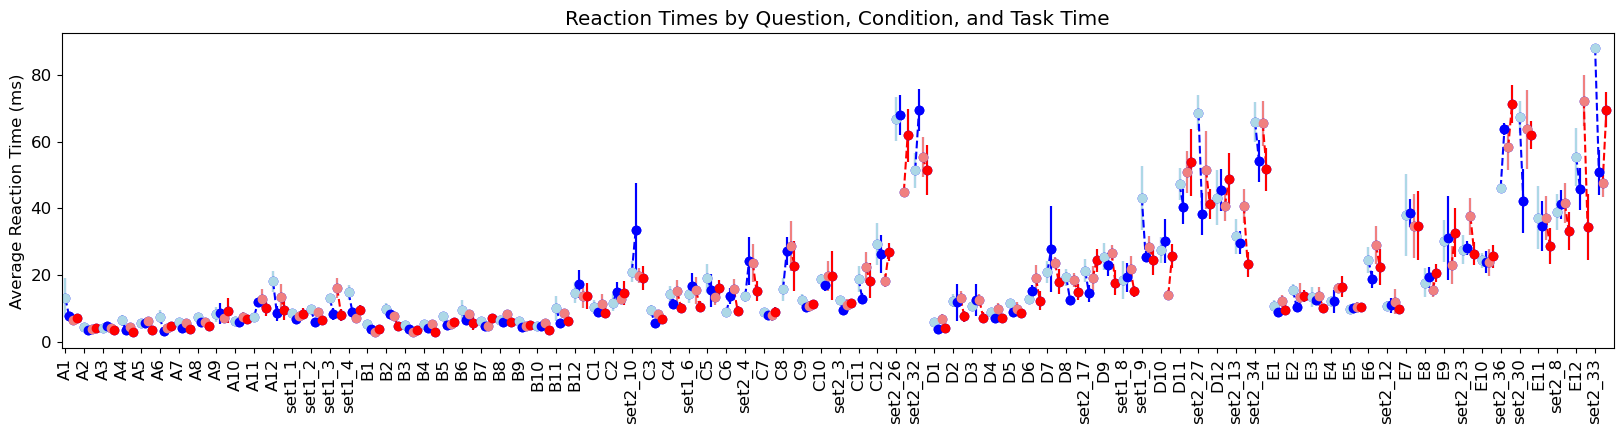

In [276]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rt_table is already created and contains the necessary data.
# Extract unique questions to plot
questions = rt_table['question'].unique()
num_questions = len(questions)

# Colors for different conditions and times
# colors = {
#     ('Sham', 'pre'): 'lightblue',
#     ('Sham', 'post'): 'blue',
#     ('Active', 'pre'): 'lightcoral',
#     ('Active', 'post'): 'red'
# }
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Initialize plot
fig, ax = plt.subplots(figsize=(num_questions * 0.2, 4.5))  # Adjusting width for each question

# Iterate over each question to plot the mean and error bars
for idx, question in enumerate(questions):
    subset = rt_table[rt_table['question'] == question]
    
    # Sort subset to ensure consistent order [Sham pre, Sham post, Active pre, Active post]
    subset = subset.sort_values(by=['condition', 'task time'], ascending=[False, False])

    # Collect means, std errors, and labels
    means = subset['average time'].values
    std_errors = subset['SEM'].values  # using SEM for error bars
    # labels = [f'{cond} {time}' for cond, time in zip(subset['condition'], subset['task time'])]

    # Plot data points and connect lines within each condition
    x_vals = np.arange(len(means)) + idx * (len(means) + 1)  # Offset each group of points
    
    ax.errorbar(x_vals, means, yerr=std_errors, fmt='o', color='blue')
    for i in range (0,4):
        ax.errorbar(x_vals[i], means[i], yerr=std_errors[i], marker='o', color=colors[i])

    ax.plot(x_vals[0:2], means[0:2], color='blue', linestyle='--')  # Connect Sham points
    ax.plot(x_vals[2:4], means[2:4], color='red', linestyle='--')  # Connect Active points

# Adjust x-axis
ax.set_xlim(-1, num_questions * (len(means) + 1))
ax.set_xticks(range(0, num_questions * (len(means) + 1), len(means) + 1))
ax.set_xticklabels(questions, rotation=90)

# Add labels and title
ax.set_ylabel('Average Reaction Time (ms)')
ax.set_title('Reaction Times by Question, Condition, and Task Time')

# Adjust layout to make room for labels
fig.tight_layout()

save_path = os.path.join('..', '..', '..', 'paper', 'behavior', 'rt_question_condition_tasktime.png')
plt.savefig(save_path, format='png', dpi=600)
plt.show()


In [273]:
rt_table

,question,condition,task time,average time,STD,SEM
0,A1,Sham,pre,13.199800,13.095052,5.856285
0,A1,Sham,post,7.746125,2.635413,0.931759
0,A1,Active,pre,6.694857,3.767641,1.424035
0,A1,Active,post,7.104000,1.729116,0.773284
0,A2,Sham,pre,4.428875,2.290804,0.809922
...,...,...,...,...,...,...
0,E12,Active,post,34.493000,22.216121,9.935351
0,set2_33,Sham,pre,88.239000,0.000000,0.000000
0,set2_33,Sham,post,50.881714,17.798401,6.727163
0,set2_33,Active,pre,47.772600,9.908609,4.431264
